## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [42]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [43]:
#looking at the first 6 rows

df = pd.read_csv("ab_data.csv")
df.head(6)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0


b. Use the cell below to find the number of rows in the dataset.

In [44]:
#Finding the number of rows

df.shape[0]

294478

c. The number of unique users in the dataset.

In [45]:
#Finding the number of unique user_id's

df.user_id.nunique()

290584

d. The proportion of users converted.

In [46]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [47]:
#Count the number of rows where new_page and control group are aligned as well as where old_page and treatment group are aligned, and add them together:

df2 = df.query('landing_page == "new_page" and group == "control"').count()[0] + df.query('landing_page == "old_page" and group == "treatment"').count()[0]

f. Do any of the rows have missing values?

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [49]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

# Double Check all of the correct rows were removed - this should be 0
df2[((df2["group"] == "treatment") == (df2["landing_page"] == "new_page")) == False].shape[0]

0

In [50]:
#Filter the rows where new_page and control don't match:

new_page_control = df[(df.landing_page == "new_page") & (df.group == "control")]

#Filter the rows where old_page and treatment don't match:

old_page_treatment = df[(df.landing_page == "old_page") & (df.group == "treatment")]

#Concatenate them together:
mismatch = pd.concat([new_page_control, old_page_treatment])

#Assign the index for mixmatch:

mismatch_index = mismatch.index

#Drop these rows:

df2 = df.drop(mismatch.index)

In [51]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [52]:
df2["user_id"].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [53]:
df2[df2.duplicated("user_id")]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [54]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [55]:
df2.drop(labels = 1899, axis = 0, inplace = True)



In [56]:
#Confirm removal:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [57]:
#1 is considered True:

df2["converted"].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [58]:
df2[df2["group"] == "control"]["converted"].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [59]:
df2[df2["group"] == "treatment"]["converted"].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [90]:
(df2.landing_page == "new_page").mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The probability difference between the control and the treatment groups is very small, hence we cannot that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$**  :  **$p_{old}$** $\ge$ **$p_{new}$**

**$H_{1}$**  :  **$p_{new}$** > **$p_{old}$**

**$H_{0}$** (Null Hypothesis) : New page has either same coversion rate or worse than old page.

**$H_{1}$** (Alternatve Hypothesis) : New page has better conversion rate than old page.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [91]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [92]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [93]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [94]:
n_old = df2[df2['group'] == 'control'].shape[0]
print("Number of users with old page :",n_old)

Number of users with old page : 145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [95]:
# Using binomial distribution to find samples with probability p_new
new_page_converted =  np.random.binomial(1, p = p_new,size = n_new)


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [96]:
# Using binomial distribution to find samples with probability p_old
old_page_converted =  np.random.binomial(1, p = p_old,size = n_old)


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [97]:
# Calculating the difference between mean of each scenarios probability

obs_diff = new_page_converted.mean() - old_page_converted.mean()

print("Difference between mean of each scenarios probability:",obs_diff)


Difference between mean of each scenarios probability: -0.0011582882173


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [98]:
p_obs_diff = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    obs_diff = new_page_converted/n_new - old_page_converted/n_old
    p_obs_diff.append(obs_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([    5.,    80.,   438.,  1422.,  2762.,  2779.,  1740.,   657.,
           97.,    20.]),
 array([-0.00470295, -0.00378892, -0.00287489, -0.00196086, -0.00104683,
        -0.0001328 ,  0.00078123,  0.00169526,  0.00260929,  0.00352332,
         0.00443735]),
 <a list of 10 Patch objects>)

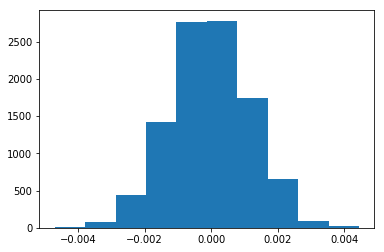

In [99]:
plt.hist(p_obs_diff)

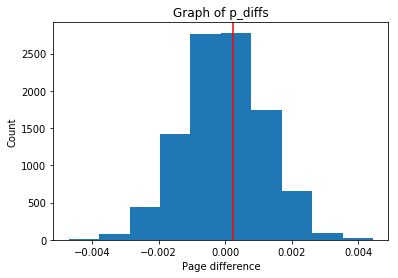

In [100]:
#histogram of p_diff
plt.hist(p_obs_diff);

plt.title('Graph of p_diffs') #title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

plt.axvline(x= obs_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [101]:
act_obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
print(act_obs_diff)
p_obs_diff = np.array(p_obs_diff)
(act_obs_diff < p_obs_diff).mean()

-0.00157823898536


0.90149999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In part j, we computed the p value, which is the probability of not observing any difference between conversion rates of control and treatment groups if the null hypothesis is true. In order to reject the nll, p-value needs to be below the agreed confidence level 0.05. Since our p-value is 0.9, it's too high for us to be able to reject the null hypothesis. We don't have enough evidence to conclude that there is conversion difference between the new and old pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [102]:
import statsmodels.api as sm

convert_old = len(df2.query('converted==1 and landing_page=="old_page"')) #rows converted with old_page
convert_new = len(df2.query('converted==1 and landing_page=="new_page"')) #rows converted with new_page
n_old = len(df2.query('landing_page=="old_page"')) #rows_associated with old_page
n_new = len(df2.query('landing_page=="new_page"')) #rows associated with new_page
n_new

145310

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [103]:
#z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

#display z_score and p_value
print(z_score,p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [104]:
from scipy.stats import norm
norm.cdf(z_score) #significance of z_score 


0.90505831275902449

In [105]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

**z_score is less than critical value of 95% confidence. Hence we fail to reject null hypothesis. Therefore the conclusion is the same as part j and we accept the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [106]:
#adding an intercept column
df2['intercept'] = 1

#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [107]:

import statsmodels.api as sm
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [108]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 25 Dec 2019   Pseudo R-squ.:               8.077e-06
Time:                        02:29:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

In logistic regression:

**$H_{1}$**  :  **$p_{new}$**  - **$p_{old}!$** = 0

Part 2:

**$H_{0}$**  :  **$p_{new}$** - **$p_{old}$** $\le$ 0

**$H_{1}$**  :  **$p_{new}$** - **$p_{old}$** > 0




f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

***Considering other factors is a good idea as these factors may contribute to the significance of our test results and lead to more accurate decisions. One of the disadvantages of adding additional terms into the regression model is Simpson's paradox in which a trend appears in several different groups of data but disappears or reverses when these groups are combined.***

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [109]:
# Store Countries.csv data in dataframe
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [110]:
#Inner join two datas
new = countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [111]:
#adding dummy variables with 'CA' as the baseline
new[['US', 'UK']] = pd.get_dummies(new['country'])[['US', "UK"]]
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [112]:
new['US_ab_page'] = new['US']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [113]:
new['UK_ab_page'] = new['UK']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [114]:
logit3 = sm.Logit(new['converted'], new[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'US_ab_page']])
logit3

In [115]:

#Check the result
result3 = logit3.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [116]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Wed, 25 Dec 2019   Pseudo R-squ.:               2.589e-05
Time:                        02:29:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2390
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0366      0.028    -72.618      0.000      -2.092      -1.982
ab_page       -0.0018      0.021     -0.086      0.931      -0.043       0.039
US             0.0501      0.030      1.691      0.091      -0.008       0.108
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US_ab_page    -0.0094   7.04e+05  -1.33e-08      1.000   -1.38e+06    1.38e+06
US_ab_page    -0.0094   7.04e+05  -1.33e-08      1.000   -1.38e+06    1.38e+06
==============================================================================
"""

None of the variables have significant p-values. Therefore, we fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

### Conclusions

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page. All methods shown in this notebook idicates that we can not reject null hypothesis. Costs of implementing new page could be higher than expected profit from increase of conversion rate. I would not recommend to launch new page on production environment.

## References

Z-score calculations : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html

Numpy Random Binomial: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.random.binomial.html

Udacity Slack channel and Knowledge page Z-Score definition : http://www.statisticshowto.com/probabili
ty-and-statistics/z-score/ 

Intercept: https://stats.stackexchange.com/questions/7948/when-is-it-ok-to-remove-the-intercept-in-a-linear-regression-model